# Model Training

This notebook is used to train a model for the sketch detection task.

In [21]:
!echo $PATH
import os

os.environ['PATH'] = os.environ['HOME'] + '/.local/bin:' + os.environ['PATH']
!echo $PATH

/root/.local/bin:/root/miniconda3/bin:/root/miniconda3/condabin:/root/.vscode-server/bin/1a5daa3a0231a0fbba4f14db7ec463cf99d7768e/bin/remote-cli:/root/miniconda3/bin:/usr/local/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
/root/.local/bin:/root/.local/bin:/root/miniconda3/bin:/root/miniconda3/condabin:/root/.vscode-server/bin/1a5daa3a0231a0fbba4f14db7ec463cf99d7768e/bin/remote-cli:/root/miniconda3/bin:/usr/local/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


In [22]:
!python3 --version

Python 3.8.10


In [23]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [24]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [25]:
# @formatter:off
# https://pytorch.org/get-started/previous-versions/
# !pip3 install --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu118 --user
# !pip install 'git+https://github.com/facebookresearch/detectron2.git' --user
# !pip install detectron2
# @formatter:on

In [26]:
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())
print(torchvision.__version__)
!gcc --version

2.0.0+cu118 True
0.15.1+cu118
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [27]:
import os

from detectron2.utils.logger import setup_logger

setup_logger()

<Logger detectron2 (DEBUG)>

## Collect Training Data

In [28]:
# 数据增强
from detectron2.data import transforms as T

def custom_augmentation():
    # 创建一个增强列表
    augmentation_list = [
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),  # 随机水平翻转
        T.RandomRotation(angle=[0, 90, 180, 270], sample_style='choice'),  # 随机旋转
        T.RandomExtent(scale_range=(0.8, 1.2), shift_range=(0.0, 0.0)),  # 随机扩展
        T.ResizeShortestEdge(short_edge_length=[640, 672, 704, 736, 768, 800], max_size=1333, sample_style='choice')  # 随机调整大小
    ]
    return T.AugmentationList(augmentation_list)

from detectron2.data import build_detection_train_loader

def mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # 它是防止对原始数据集造成影响
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = custom_augmentation()
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        obj_transform(a, transforms)
        for a in dataset_dict.pop("annotations")
        if obj_transform(a, transforms) is not None
    ]
    dataset_dict["annotations"] = annos
    return dataset_dict

def custom_train_loader(cfg):
    return build_detection_train_loader(cfg, mapper=mapper)



In [29]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from src.utils.utils_json import print_json, read_json
from src.dataset.dataset import read_dateset_from

# @formatter:off
# datadir = "datasets/fa"
datadir = "datasets/fcb"
# datadir = "Sketches-Dataset-main/data"
# @formatter:on

training_meta_path = os.path.join(datadir, "train.json")
classes = list(map(lambda x: x["name"], read_json(training_meta_path)["categories"]))
classes.sort()

print_json(classes, tag="Classes")


def on_register_dataset(x):
    dataset = read_dateset_from(datadir, x)
    return dataset


for d in ["train", "val"]:
    name = "sketches_" + d

    # Remove previously registered datasets if they exist
    try:
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    except KeyError:
        pass

    # Register new dataset
    DatasetCatalog.register(name, lambda x=d: on_register_dataset(x))
    MetadataCatalog.get(name).set(thing_classes=classes)

Classes [
  "arrow",
  "connection",
  "data",
  "decision",
  "process",
  "terminator",
  "text"
]


In [30]:
from detectron2.utils.visualizer import Visualizer

import cv2
import random

sketches_metadata = MetadataCatalog.get("sketches_train")
training_dataset = read_dateset_from(datadir, "train")

In [31]:
# https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#metadata-for-datasets
MetadataCatalog.get("sketches_train").keypoint_names = [
    "head",
    "tail",
]

MetadataCatalog.get("sketches_train").keypoint_flip_map = (
    ("head", "tail"),
    ("tail", "head"),
)

print_json(MetadataCatalog.get("sketches_train").thing_classes, tag="thing_classes")
print_json(MetadataCatalog.get("sketches_train").keypoint_names, tag="keypoint_names")

thing_classes [
  "arrow",
  "connection",
  "data",
  "decision",
  "process",
  "terminator",
  "text"
]
keypoint_names [
  "head",
  "tail"
]


## Configure Model Training

In [32]:
from names_generator import generate_name

model_name = "fcb_8"
print(f"Model name: '{model_name}'")

Model name: 'fcb_8'


In [33]:
import multiprocessing
from detectron2 import model_zoo
from detectron2.config import get_cfg

from src.utils.utils_json import write_json
from src.sketch_detection_rcnn.roi_heads import SketchROIHeads  # noqa # pylint: disable=unused-import

pretrained_model = "COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"

cfg = get_cfg()

# Use pre-trained model
cfg.merge_from_file(model_zoo.get_config_file(pretrained_model))
print_json(cfg)
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pretrained_model) sourcecode/lissa-diagram-recognition/notebooks/models/fcb_2/model_final.pth
cfg.MODEL.WEIGHTS = "/root/sourcecode/Graduation-Design/notebooks/models/fcb_7/model_final.pth"
# Use pre-pre-trained model
# cfg.merge_from_file(model_zoo.get_config_file(pretrained_model))
# cfg.MODEL.WEIGHTS = "/home/jupyter-patrickzierahn/models/clever_mahavira/model_final.pth"

cfg.OUTPUT_DIR = os.path.join("models", model_name)

# Set training data
cfg.DATALOADER.NUM_WORKERS = multiprocessing.cpu_count()
cfg.DATASETS.TRAIN = ("sketches_train",)
cfg.DATASETS.TEST = ("sketches_val",)

# Set the backbone to be trainable
cfg.MODEL.BACKBONE.FREEZE_AT = 0

# pick a good LR
# 设置动量
cfg.SOLVER.MOMENTUM = 0.9

# 设置权重衰减
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.BASE_LR = 0.00001
cfg.SOLVER.STEPS = (30000, 40000)
cfg.SOLVER.MAX_ITER = 100
cfg.SOLVER.IMS_PER_BATCH = 1



# Region of Interest
cfg.MODEL.ROI_HEADS.NAME = "SketchROIHeads"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

# Keypoints
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 2
cfg.TEST.KEYPOINT_OKS_SIGMAS = [1.0] * cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS

# Write config to file
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg_file = os.path.join(cfg.OUTPUT_DIR, "cfg.json")
write_json(cfg_file, cfg)

# Write class names to file
classes_file = os.path.join(cfg.OUTPUT_DIR, "classes.json")
write_json(classes_file, classes)

# Print config
print_json(cfg)

{
  "CUDNN_BENCHMARK": false,
  "DATALOADER": {
    "ASPECT_RATIO_GROUPING": true,
    "FILTER_EMPTY_ANNOTATIONS": true,
    "NUM_WORKERS": 4,
    "REPEAT_THRESHOLD": 0.0,
    "SAMPLER_TRAIN": "TrainingSampler"
  },
  "DATASETS": {
    "PRECOMPUTED_PROPOSAL_TOPK_TEST": 1000,
    "PRECOMPUTED_PROPOSAL_TOPK_TRAIN": 2000,
    "PROPOSAL_FILES_TEST": [],
    "PROPOSAL_FILES_TRAIN": [],
    "TEST": [
      "keypoints_coco_2017_val"
    ],
    "TRAIN": [
      "keypoints_coco_2017_train"
    ]
  },
  "GLOBAL": {
    "HACK": 1.0
  },
  "INPUT": {
    "CROP": {
      "ENABLED": false,
      "SIZE": [
        0.9,
        0.9
      ],
      "TYPE": "relative_range"
    },
    "FORMAT": "BGR",
    "MASK_FORMAT": "polygon",
    "MAX_SIZE_TEST": 1333,
    "MAX_SIZE_TRAIN": 1333,
    "MIN_SIZE_TEST": 800,
    "MIN_SIZE_TRAIN": [
      640,
      672,
      704,
      736,
      768,
      800
    ],
    "MIN_SIZE_TRAIN_SAMPLING": "choice",
    "RANDOM_FLIP": "horizontal"
  },
  "MODEL": {
    "ANCHO

## Print Model Layers

In [34]:
from detectron2.modeling import build_model

model = build_model(cfg)

## Train Model

In [35]:
import time
from detectron2.engine import DefaultTrainer

start_time = time.time()

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return custom_train_loader(cfg)
    
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

training_duration = time.time() - start_time

[11/29 21:04:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/root/.local/lib/python3.8/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/root/.local/lib/python3.8/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/root/.local/lib/python3.8/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please con

[11/29 21:04:33 d2.utils.events]:  eta: 0:00:38  iter: 19  total_loss: 0.05132  loss_cls: 0.01912  loss_box_reg: 0.002501  loss_arrow_reg: 0.01347  loss_rpn_cls: 0.0002769  loss_rpn_loc: 0.01087    time: 0.4381  last_time: 0.4094  data_time: 0.4062  last_data_time: 0.0008   lr: 1.9081e-06  max_mem: 4881M
[11/29 21:04:42 d2.utils.events]:  eta: 0:00:27  iter: 39  total_loss: 0.04646  loss_cls: 0.01999  loss_box_reg: 0.002546  loss_arrow_reg: 0.01159  loss_rpn_cls: 0.0002076  loss_rpn_loc: 0.01066    time: 0.4372  last_time: 0.4654  data_time: 0.0037  last_data_time: 0.0009   lr: 3.9061e-06  max_mem: 4881M
[11/29 21:04:50 d2.utils.events]:  eta: 0:00:17  iter: 59  total_loss: 0.0609  loss_cls: 0.02355  loss_box_reg: 0.002614  loss_arrow_reg: 0.01759  loss_rpn_cls: 0.0002015  loss_rpn_loc: 0.01163    time: 0.4312  last_time: 0.4114  data_time: 0.0008  last_data_time: 0.0007   lr: 5.9041e-06  max_mem: 4881M
[11/29 21:04:58 d2.utils.events]:  eta: 0:00:08  iter: 79  total_loss: 0.04854  los

## Gather Evaluation Metrics

In [36]:
from detectron2.engine import DefaultPredictor

# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/29 21:05:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models/fcb_8/model_final.pth ...


datasets/fcb/val/writer011_fc_012b.png


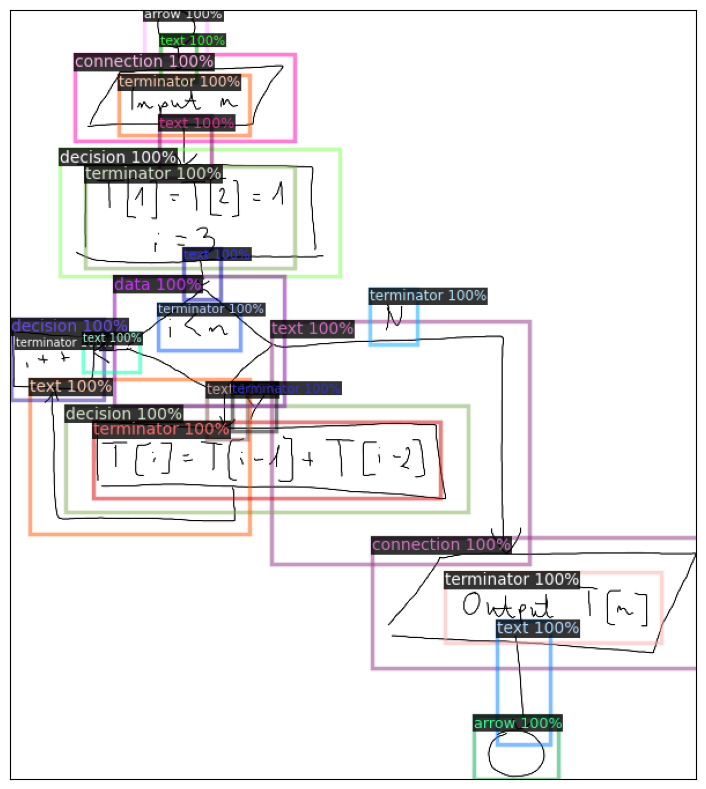

In [37]:
%matplotlib inline
from src.visualization.visualize import show_img

validation_dataset = read_dateset_from(datadir, "val")

for record in random.sample(validation_dataset, 1):
    im = cv2.imread(record["file_name"])
    print(record["file_name"])
    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    outputs = predictor(im)

    # print_json(record, tag="record")
    # print("outputs", outputs)

    # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    v = Visualizer(im, metadata=sketches_metadata, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    show_img(out.get_image())

In [38]:
from detectron2.evaluation import COCOEvaluator

outdir = os.path.join("reports", model_name)
os.makedirs(outdir, exist_ok=True)

test_datasets = cfg.DATASETS.TEST
evaluator = [
    COCOEvaluator(
        test_set,
        cfg,
        distributed=False,
        output_dir=outdir,
    )
    for test_set in test_datasets
]

metrics = DefaultTrainer.test(cfg, predictor.model, evaluator)

WARNING [11/29 21:05:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/29 21:05:13 d2.evaluation.coco_evaluation]: Trying to convert 'sketches_val' to COCO format ...
WARNING [11/29 21:05:13 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'reports/fcb_8/sketches_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[11/29 21:05:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/29 21:05:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/29 21:05:14 d2.data.common]: Serializing 196 elements to byte tensors and concatenating them all ...
[11/29 21:05:14 d2.data.common]: Serialized dataset takes 0.86 MiB
[11/29 21:05:14 d2.evaluation.evaluator]: Start

In [39]:
from datetime import datetime

# Convert inference to a dict and remove NaN values
inference_dict = dict((k, v) for k, v in metrics.items())
metrics_file = os.path.join(cfg.OUTPUT_DIR, "metrics.json")

report = {
    "model_name": model_name,
    "training_time": training_duration,
    "training_data": datadir,
    "model_path": cfg.OUTPUT_DIR,
    "config_file": cfg_file,
    "inference": inference_dict,
    "metrics_file": metrics_file,
    "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

report_file = f"reports/{model_name}.json"
write_json(report_file, report)

print_json(report)

{
  "config_file": "models/fcb_8/cfg.json",
  "date": "2023-11-29 21:05:48",
  "inference": {
    "bbox": {
      "AP": 85.06348550180822,
      "AP-arrow": 69.57841730118957,
      "AP-connection": 87.17280741845047,
      "AP-data": 96.1473945080944,
      "AP-decision": 88.31481901762902,
      "AP-process": 77.26720525439492,
      "AP-terminator": 88.19142140358073,
      "AP-text": 88.77233360931832,
      "AP50": 99.39220785255512,
      "AP75": 97.50781431358581,
      "APl": 85.77560592410734,
      "APm": 70.59411363316765,
      "APs": NaN
    }
  },
  "metrics_file": "models/fcb_8/metrics.json",
  "model_name": "fcb_8",
  "model_path": "models/fcb_8",
  "training_data": "datasets/fcb",
  "training_time": 58.69573378562927
}


In [40]:
print(f"Model name: '{model_name}', training time: {training_duration / 60:.0f} minutes")

Model name: 'fcb_8', training time: 1 minutes
